 - https://microsoft.github.io/dowhy/example_notebooks/dowhy_simple_example.html

In [1]:
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Config dict to set the logging level
import logging
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
logging.info("Getting started with DoWhy. Running notebook...")

# 0. data
- `beta`가 true causal effect

In [2]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5,
        num_instruments = 2,
        num_effect_modifiers=1,
        num_samples=5000,
        treatment_is_binary=True,
        stddev_treatment_noise=10,
        num_discrete_common_causes=1)
df = data["df"]

In [3]:
# 현재 dowhy는 pandas dataframe만 input으로 사용
df.head()

,X0,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,0.971155,1.0,0.983871,0.254491,1.537766,2.728831,0.405794,2,True,35.897518
1,-0.008984,0.0,0.649192,-1.718428,-1.486643,0.459921,0.874968,2,False,-0.971724
2,0.468398,1.0,0.615669,-0.695340,-0.684092,0.599958,0.045433,3,True,15.913232
3,-0.331048,0.0,0.989380,0.034818,-0.930087,1.432913,0.826309,0,True,14.364757
4,1.085689,1.0,0.367563,-0.986637,0.174001,0.773636,-0.931235,1,True,11.070614


- `data`에 들어있는 값들 (`df` 제외)

```
- 'treatment_name': ['v0'],
- 'outcome_name': 'y',
- 'common_causes_names': ['W0', 'W1', 'W2', 'W3', 'W4'],
- 'instrument_names': ['Z0', 'Z1'],
- 'effect_modifier_names': ['X0'],
- 'frontdoor_variables_names': [],
- 'dot_graph': 'digraph {v0->y;W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;X0-> y;}',
- 'gml_graph': 'graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ source "W4" target "v0"]edge[ source "Z0" target "v0"] edge[ source "Z1" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"] edge[ source "W4" target "y"]node[ id "X0" label "X0"] edge[ source "X0" target "y"]]',
 'ate': 12.852576193620925}

```

# 1. Model causal mechanisms

In [4]:
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"] # 공홈에서 dot_graph보다 gml_graph를 recommend함
        )

- simulation data가 아니라 기존의 data를 이용하려면 위의 format을 그래도 작성하면 된다
- [DAGitty](http://dagitty.net/dags.html#) 사이트를 이용할 수도 있다
- 예시

```python
causal_graph = """
digraph {
High_limit;
Churn;
Income_Category;
Education_Level;
Customer_Age;
U[label="Unobserved Confounders"];
Customer_Age -> Education_Level; Customer_Age -> Income_Category;
Education_Level -> Income_Category; Income_Category->High_limit;
U->Income_Category;U->High_limit;U->Churn;
High_limit->Churn; Income_Category -> Churn;
}
"""

model= CausalModel(
        data = training, # dataframe
        graph=causal_graph.replace("\n", " "),
        treatment='High_limit',
        outcome='Churn')
```

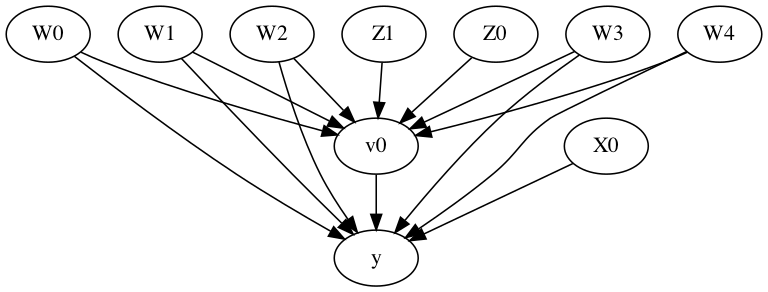

In [5]:
model.view_model()

from IPython.display import Image, display
display(Image(filename="causal_model.png"))

# 2. Identify the target estimand

In [10]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
# proceed_when_unidentifiable. It needs to be set to True
# to convey the assumption that we are ignoring any unobserved confounding

print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W1,W2,W4,W0])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W2,W4,W0,U) = P(y|v0,W3,W1,W2,W4,W0)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



# 3. Estimate causal effect

In [11]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)

propensity_score_stratification
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W1,W2,W4,W0])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W1,W2,W4,W0,U) = P(y|v0,W3,W1,W2,W4,W0)

## Realized estimand
b: y~v0+W3+W1+W2+W4+W0
Target units: ate

## Estimate
Mean value: 10.257618758277024



In [8]:
print(causal_estimate.value)

10.257618758277024


# 4. Refute estimate

In [12]:
# Adding a random common cause variable
res_random=model.refute_estimate(identified_estimand, causal_estimate,
        method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:10.257618758277024
New effect:10.248267927943052
p value:0.45999999999999996



In [13]:
# Replacing treatment with a random (placebo) variable
res_placebo=model.refute_estimate(identified_estimand, causal_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)


Refute: Use a Placebo Treatment
Estimated effect:10.257618758277024
New effect:0.004448677029791578
p value:0.49



In [14]:
# Removing a random subset of the data
res_subset=model.refute_estimate(identified_estimand, causal_estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:10.257618758277024
New effect:10.220266223065927
p value:0.37

